<a href="https://colab.research.google.com/github/PintoBI/Cole-Moore/blob/main/Cole_Moore_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/pintobi/Cole-Moore

Cloning into 'Cole-Moore'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 578.73 KiB | 4.86 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [5]:
# Import the module
import sys
sys.path.append('/content/Cole-Moore')
from data_loader import load_data

# Import other necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from google.colab import files
import os

# Upload a data file
print("Please upload your electrophysiology data file (e.g., .csv, .txt, .asc). If not file is ulpoaded example simulated data will be used")
uploaded = files.upload()

# Process the uploaded file
if uploaded:
    file_name = next(iter(uploaded))
    file_content = uploaded[file_name]
    print(f"\nUploaded file: {file_name}")
elif os.path.exists('/content/Cole-Moore/Example/simulation.txt'):
    file_name = '/content/Cole-Moore/Example/simulation.txt'
    with open(file_name, 'rb') as f:
        file_content = f.read()
    print(f"\nNo file uploaded. Using sample file: {file_name}")
else:
    print("No file uploaded and sample file not found. Please upload a file manually.")
    file_name = None
    file_content = None

if file_name and file_content:
    # Use your load_data function
    data = load_data(
        filename=file_name,
        file_content=file_content,
        header_lines=1,
        time_col_hint='Time',
        delimiter=None
    )

    if data is not None:
        print("\n--- Data Preview ---")
        display(data.head())


Please upload your electrophysiology data file (e.g., .csv, .txt, .asc):



No file uploaded. Using sample file: /content/Cole-Moore/Example/simulation.txt
Reading data from uploaded file: /content/Cole-Moore/Example/simulation.txt (UTF-8)
File '/content/Cole-Moore/Example/simulation.txt' has 15002 lines
Found potential header at line 1: Time (ms)	Sweep 1	Sweep 2	Sweep 3	Sweep 4	Sweep 5	Sweep 6	Sweep 7	Sweep 8	Sweep ...
Detected tab delimiter in header.
Attempting to parse with delimiter='	' and skiprows=0
Successfully parsed with delimiter='	'
Cleaned columns: ['Time (ms)', 'Sweep 1', 'Sweep 2', 'Sweep 3', 'Sweep 4', 'Sweep 5', 'Sweep 6', 'Sweep 7', 'Sweep 8', 'Sweep 9', 'Sweep 10', 'Sweep 11']
Found time column matching hint 'Time': 'Time (ms)'
Detected time unit as milliseconds in 'Time (ms)'. No conversion needed.
Found 11 valid sweep columns: ['Sweep 1', 'Sweep 2', 'Sweep 3', 'Sweep 4', 'Sweep 5', 'Sweep 6', 'Sweep 7', 'Sweep 8', 'Sweep 9', 'Sweep 10', 'Sweep 11']
Data loaded successfully. Shape: (15001, 12)

--- Data Preview ---


,Time (ms),Sweep 1,Sweep 2,Sweep 3,Sweep 4,Sweep 5,Sweep 6,Sweep 7,Sweep 8,Sweep 9,Sweep 10,Sweep 11
0,0.000,0.500147,0.140429,0.032155,0.006091,0.000976,0.000136,0.000017,0.000002,1.988708e-07,1.961894e-08,1.844143e-09
1,0.001,0.502624,0.141456,0.032507,0.006192,0.001001,0.000141,0.000018,0.000002,2.310759e-07,2.489804e-08,2.693668e-09
2,0.002,0.505108,0.142489,0.032862,0.006294,0.001026,0.000147,0.000019,0.000002,2.672994e-07,3.125226e-08,3.829879e-09
3,0.003,0.507601,0.143527,0.033219,0.006398,0.001052,0.000152,0.000020,0.000003,3.079015e-07,3.883695e-08,5.319887e-09
4,0.004,0.510102,0.144570,0.033580,0.006503,0.001078,0.000158,0.000021,0.000003,3.532629e-07,4.782123e-08,7.239702e-09


In [7]:
"""
Example script for using the voltage_converter module

This script assumes that 'data' has already been loaded and is available in the environment.
It converts sweep column headers to voltage values using the voltage_converter module.
"""

# Import the voltage_converter module
from voltage_converter import rename_sweep_columns_to_voltage

# Check if data is available
if 'data' in locals() and data is not None:
    print("\n--- Renaming Sweep Columns to Voltage Values ---")

    # User-specified voltage parameters
    initial_voltage = -60   # mV, voltage of the first sweep
    voltage_step = -5     # mV, voltage difference between consecutive sweeps

    print(f"Initial voltage: {initial_voltage} mV")
    print(f"Voltage step: {voltage_step} mV")

    # Rename the columns
    voltage_data = rename_sweep_columns_to_voltage(
        data,
        time_col='Time (ms)',
        initial_voltage=initial_voltage,
        voltage_step=voltage_step
    )

    # Replace data with the renamed version for subsequent processing
    data = voltage_data

    # Display the first few rows to verify
    print("\n--- Data with Voltage Headers (first 5 rows) ---")
    from IPython.display import display
    display(data.head())

    print("\n--- Column Renaming Complete ---")

else:
    print("\n--- Skipping Sweep to Voltage Renaming ---")
    print("Variable 'data' not found. Please run the data import cell first.")


--- Renaming Sweep Columns to Voltage Values ---
Initial voltage: -60 mV
Voltage step: -5 mV
Columns are already in voltage format. No changes needed.

--- Data with Voltage Headers (first 5 rows) ---


,Time (ms),-60 mV,-65 mV,-70 mV,-75 mV,-80 mV,-85 mV,-90 mV,-95 mV,-100 mV,-105 mV,-110 mV
0,0.000,0.500147,0.140429,0.032155,0.006091,0.000976,0.000136,0.000017,0.000002,1.988708e-07,1.961894e-08,1.844143e-09
1,0.001,0.502624,0.141456,0.032507,0.006192,0.001001,0.000141,0.000018,0.000002,2.310759e-07,2.489804e-08,2.693668e-09
2,0.002,0.505108,0.142489,0.032862,0.006294,0.001026,0.000147,0.000019,0.000002,2.672994e-07,3.125226e-08,3.829879e-09
3,0.003,0.507601,0.143527,0.033219,0.006398,0.001052,0.000152,0.000020,0.000003,3.079015e-07,3.883695e-08,5.319887e-09
4,0.004,0.510102,0.144570,0.033580,0.006503,0.001078,0.000158,0.000021,0.000003,3.532629e-07,4.782123e-08,7.239702e-09



--- Column Renaming Complete ---



--- Configuring Normalization ---
Selected Method: divide
Calculation Window: [1, 100] ms
Applying 'divide' normalization using window [1, 100] ms.
Automatic polarity detection enabled
  -60 mV: Scaled by max (6.2218e+01) - positive current
  -65 mV: Scaled by max (6.2214e+01) - positive current
  -70 mV: Scaled by max (6.2209e+01) - positive current
  -75 mV: Scaled by max (6.2206e+01) - positive current
  -80 mV: Scaled by max (6.2203e+01) - positive current
  -85 mV: Scaled by max (6.2202e+01) - positive current
  -90 mV: Scaled by max (6.2200e+01) - positive current
  -95 mV: Scaled by max (6.2199e+01) - positive current
  -100 mV: Scaled by max (6.2199e+01) - positive current
  -105 mV: Scaled by max (6.2198e+01) - positive current
  -110 mV: Scaled by max (6.2198e+01) - positive current
Normalization applied.

--- Normalized Data (first 5 rows) ---


,Time (ms),-60 mV,-65 mV,-70 mV,-75 mV,-80 mV,-85 mV,-90 mV,-95 mV,-100 mV,-105 mV,-110 mV
0,0.000,0.008039,0.002257,0.000517,0.000098,0.000016,0.000002,2.705080e-07,3.052818e-08,3.197348e-09,3.154257e-10,2.964954e-11
1,0.001,0.008078,0.002274,0.000523,0.000100,0.000016,0.000002,2.873616e-07,3.356860e-08,3.715125e-09,4.003010e-10,4.330792e-11
2,0.002,0.008118,0.002290,0.000528,0.000101,0.000016,0.000002,3.050331e-07,3.684437e-08,4.297509e-09,5.024617e-10,6.157556e-11
3,0.003,0.008158,0.002307,0.000534,0.000103,0.000017,0.000002,3.235512e-07,4.036863e-08,4.950290e-09,6.244054e-10,8.553143e-11
4,0.004,0.008199,0.002324,0.000540,0.000105,0.000017,0.000003,3.429450e-07,4.415501e-08,5.679588e-09,7.688512e-10,1.163976e-10


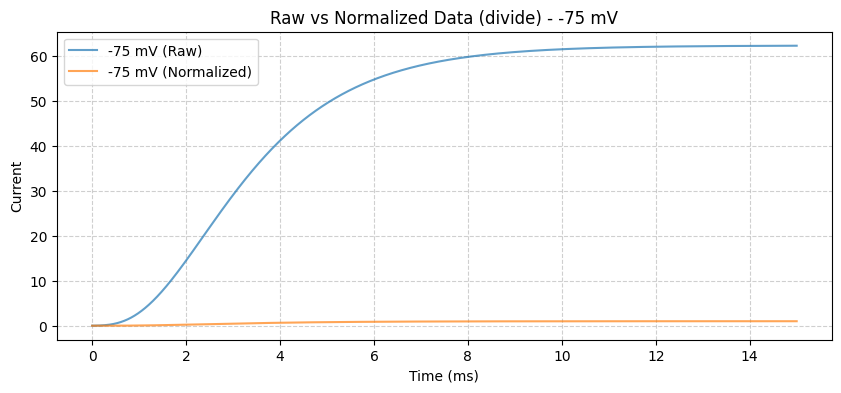

In [8]:
"""
Example script for using the normalizer module

This script assumes that 'data' has already been loaded and is available in the environment.
It normalizes the data using the specified method and time window.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Import the normalizer module
from normalize import normalize_data_window

# --- Configure and Apply Normalization ---
# Check if data exists
if 'data' in locals() and data is not None:
    print("\n--- Configuring Normalization ---")

    # --- Select Normalization Parameters ---
    # Options: 'subtract', 'divide', 'normalize', 'none'
    normalization_method = 'divide'

    # Time window (in ms) for calculating baseline or min/max
    # Set to None to use the start/end of the data trace
    norm_start_time_ms = 1     # ms, Start time for normalization window
    norm_end_time_ms = 100      # ms, End time for normalization window

    print(f"Selected Method: {normalization_method}")
    print(f"Calculation Window: [{norm_start_time_ms}, {norm_end_time_ms}] ms")

    # Apply normalization
    normalized_data = normalize_data_window(
        data,
        time_col='Time (ms)',  # Should be standard name from load_data
        method=normalization_method,
        start_time_ms=norm_start_time_ms,
        end_time_ms=norm_end_time_ms
    )

    if normalized_data is not None:
        print("\n--- Normalized Data (first 5 rows) ---")
        display(normalized_data.head())

        # Optional: Basic plot to compare raw vs normalized for the first sweep
        first_sweep = normalized_data.columns[4]  # Get name of first sweep column
        plt.figure(figsize=(10, 4))
        plt.plot(data['Time (ms)'], data[first_sweep], label=f'{first_sweep} (Raw)', alpha=0.7)
        plt.plot(normalized_data['Time (ms)'], normalized_data[first_sweep], label=f'{first_sweep} (Normalized)', alpha=0.7)
        plt.title(f'Raw vs Normalized Data ({normalization_method}) - {first_sweep}')
        plt.xlabel('Time (ms)')
        plt.ylabel('Current')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    else:
        print("\n--- Normalization Failed ---")
        # You might want to assign data to normalized_data here if you want subsequent cells to run
        # normalized_data = data.copy()
        # print("Using raw data for subsequent steps as normalization failed.")

else:
    print("\n--- Skipping Normalization ---")
    print("Variable 'data' not found. Please run the data import cell first.")
    normalized_data = None  # Ensure variable exists but is None



--- Configuring Exponential Fit Analysis ---
Selected Exponential Type: single
Fitting Window: [0.6, 100] ms
Fitting Range: 30% to 99% of amplitude
Display Range: 0 to 10 ms
Processing 11 sweep columns with 1-exponential fitting
Finished: 11 of 11 sweeps produced fits.
Showing 6 of 11 valid sweeps


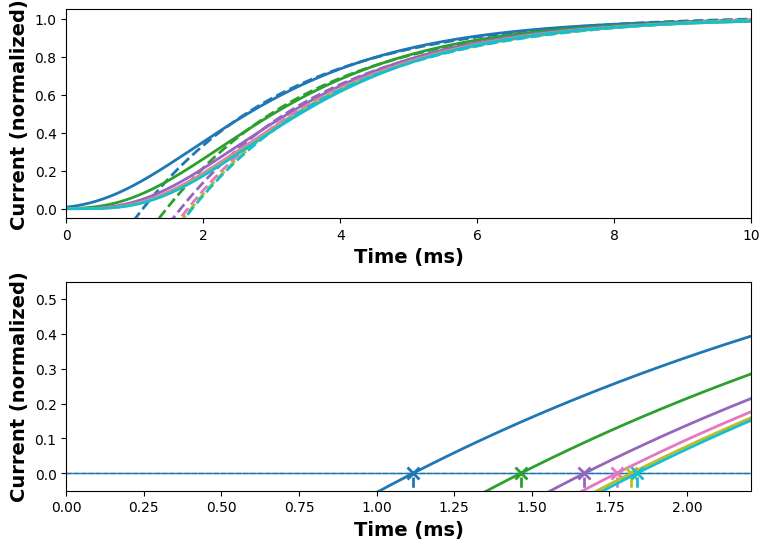

,Sweep,Crossing Time (ms),RMSE,Tau1 (ms),Component1 (%)
0,-60 mV,1.117257,0.005028,2.224193,100.0
1,-65 mV,1.309757,0.005449,2.247413,100.0
2,-70 mV,1.464316,0.005701,2.261305,100.0
3,-75 mV,1.582807,0.005842,2.269140,100.0
4,-80 mV,1.669686,0.005920,2.273580,100.0
5,-85 mV,1.731021,0.005966,2.276241,100.0
6,-90 mV,1.773272,0.005986,2.277521,100.0
7,-95 mV,1.801284,0.006004,2.278566,100.0
8,-100 mV,1.819843,0.006009,2.278906,100.0
9,-105 mV,1.831676,0.006016,2.279306,100.0


Results saved to cole_moore_exp_fit_results_single.csv


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from google.colab import files

from exponential_fit import analyze_with_exponential_fit, visualize_exponential_fits
# (Optionally available too: analyze_single, analyze_double, analyze_triple)

# --- Run Exponential Fit Analysis ---
if 'normalized_data' in locals() and normalized_data is not None:
    print("\n--- Configuring Exponential Fit Analysis ---")

    # --- Set Analysis Parameters ---
    exp_type = 'single'        # 'single' | 'double' | 'triple'
    # n_exp = 3                 # (optional override) 1, 2, or 3 — uncomment to force it

    start_time = 0.6          # ms
    end_time = 100              # ms
    baseline_percent = 30      # %
    max_percent = 99           # %
    display_max_time = 10      # ms

    print(f"Selected Exponential Type: {exp_type}")
    print(f"Fitting Window: [{start_time}, {end_time if end_time is not None else 'end'}] ms")
    print(f"Fitting Range: {baseline_percent}% to {max_percent}% of amplitude")
    print(f"Display Range: 0 to {display_max_time} ms")

    # Run the analysis
    exp_fit_results = analyze_with_exponential_fit(
        normalized_data,
        time_col='Time (ms)',
        start_time=start_time,
        end_time=end_time,
        baseline_percent=baseline_percent,
        max_percent=max_percent,
        exp_type=exp_type,   # keep this...
        # n_exp=n_exp,       # ...or pass this to override exp_type
    )

    # Visualize (NOTE: no exp_type parameter here)
    if exp_fit_results:
        results_df = visualize_exponential_fits(
            normalized_data,
            exp_fit_results,
            time_col='Time (ms)',
            x_min=0,
            x_max=display_max_time,
            max_sweeps=6
        )

        # Save & download
        if results_df is not None:
            results_filename = f"cole_moore_exp_fit_results_{exp_type}.csv"
            results_df.to_csv(results_filename, index=False)
            print(f"Results saved to {results_filename}")
            #files.download(results_filename)

else:
    print("\n--- Skipping Exponential Fit Analysis ---")
    print("Variable 'normalized_data' not found. Please run the data normalization cell first.")



--- Configuring Trace Alignment Analysis ---
Alignment Method: single_threshold
Alignment Threshold: 50.0% of peak
Reference Sweep: -60 mV
Analysis Start Time: 0.1 ms
Exclude Outliers: No
Rising Phase Only: Yes
Auto-Detect Polarity: Yes
Processing 11 sweep columns for alignment
Alignment method: single_threshold
Using rising phase only for alignment (before inactivation)
Using specified sweep -60 mV as reference
Reference rising phase: 0 to 15.000 ms (14901 points)
Reference alignment point at 2.6490 ms (50.0% of peak)
Successfully calculated shifts for 11 of 11 sweeps
Limiting visualization to 6 of 11 valid sweeps


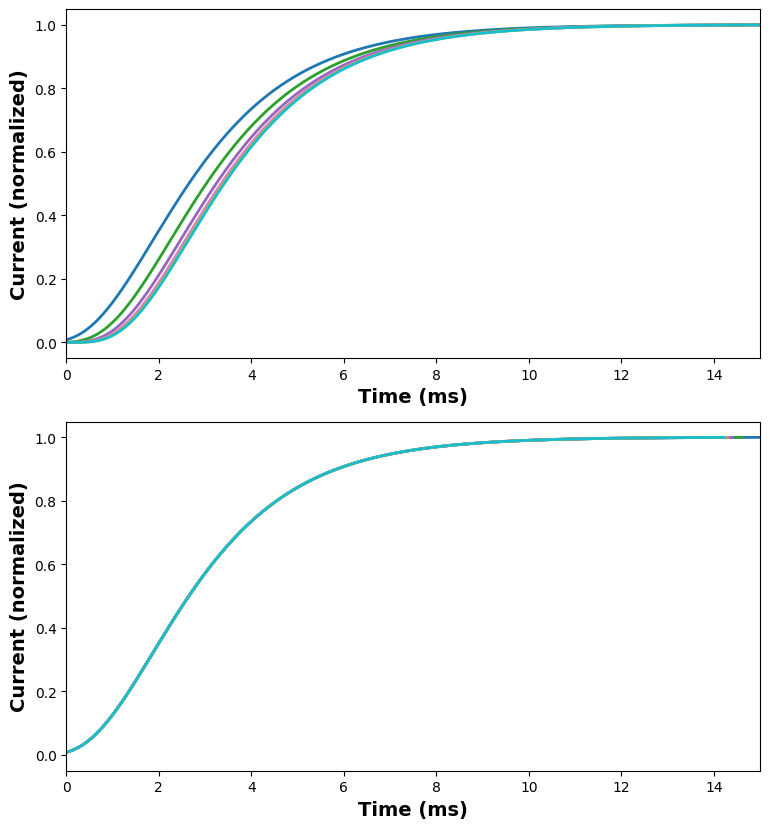


Trace Alignment Results:


,Sweep,Shift (ms),Is Reference
0,-100 mV,-0.747,No
1,-105 mV,-0.759,No
2,-110 mV,-0.766,No
3,-60 mV,0.000,Yes
4,-65 mV,-0.212,No
5,-70 mV,-0.378,No
6,-75 mV,-0.502,No
7,-80 mV,-0.593,No
8,-85 mV,-0.656,No
9,-90 mV,-0.699,No


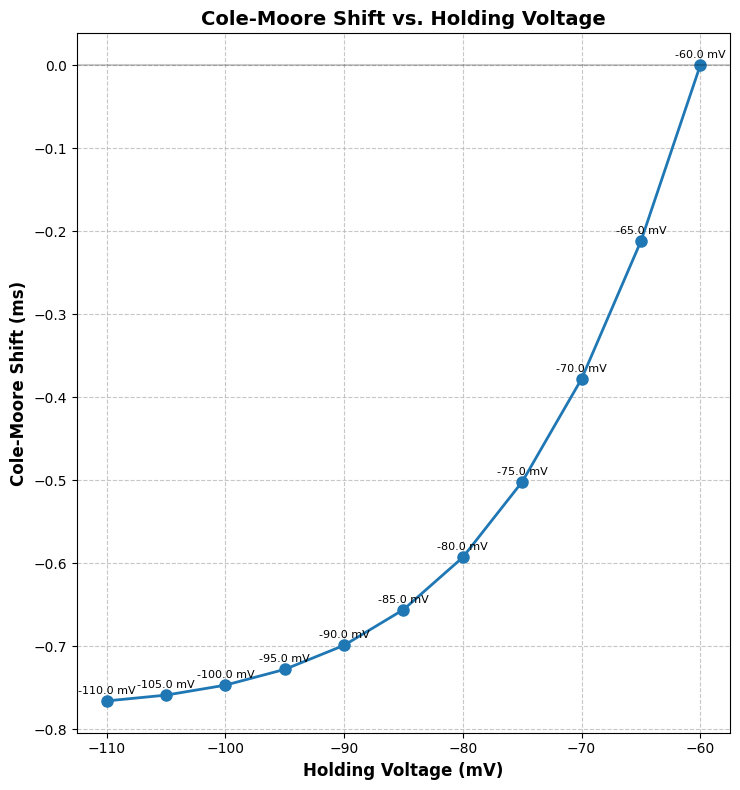


Cole-Moore Shift Statistics:
Minimum Shift: -0.766 ms at -110.0 mV
Maximum Shift: 0.000 ms at -60.0 mV
Shift Range: 0.766 ms
Mean Shift: -0.549 ms
Median Shift: -0.656 ms
Results saved to cole_moore_shift_results.csv


In [20]:
"""
Script for using the trace_aligner module for Cole-Moore analysis

This script aligns traces by their rising phase (activation kinetics) and visualizes
the results. It handles both positive and negative currents automatically.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from google.colab import files

# Import the trace_aligner module
from trace_aligner import align_traces, visualize_aligned_traces, plot_cole_moore_shifts

# --- Run Trace Alignment Analysis ---
if 'normalized_data' in locals() and normalized_data is not None:
    print("\n--- Configuring Trace Alignment Analysis ---")

    # --- Set Analysis Parameters ---
    rising_phase_only = True       # Focus only on rising phase (activation) for alignment
    alignment_method = 'single_threshold'  # 'single_threshold', 'multi_threshold', or 'curve_fit'
    alignment_threshold = 0.5      # For single threshold method - percent of amplitude (0.0-1.0)
    threshold_points = 1           # For multi-threshold method - number of points to use
    exclude_outliers = False        # Exclude outliers from alignment
    reference_sweep = '-60 mV'     # None for automatic selection based on typical kinetics
    start_time = 0.1               # ms, Start time for analysis (None for all data)
    max_shift = 50.0               # ms, Maximum allowable shift
    display_x_max = 15             # ms, Maximum time to display on x-axis
    auto_detect_polarity = True    # Automatically detect negative currents
    num_sweeps = 6

    print(f"Alignment Method: {alignment_method}")
    if alignment_method == 'single_threshold':
        print(f"Alignment Threshold: {alignment_threshold*100}% of peak")
    elif alignment_method == 'multi_threshold':
        print(f"Using {threshold_points} threshold points for robust alignment")

    print(f"Reference Sweep: {'Auto-select' if reference_sweep is None else reference_sweep}")
    print(f"Analysis Start Time: {start_time if start_time is not None else 'Beginning of trace'} ms")
    print(f"Exclude Outliers: {'Yes' if exclude_outliers else 'No'}")
    print(f"Rising Phase Only: {'Yes' if rising_phase_only else 'No'}")
    print(f"Auto-Detect Polarity: {'Yes' if auto_detect_polarity else 'No'}")

        # Run the alignment
    shift_results = align_traces(
        normalized_data,
        time_col='Time (ms)',
        reference_sweep=reference_sweep,
        start_time=start_time,
        rising_phase_only=rising_phase_only,
        alignment_threshold=alignment_threshold,
        alignment_method=alignment_method,
        threshold_points=threshold_points,
        exclude_outliers=exclude_outliers,
        max_shift=max_shift,
        auto_detect_polarity=auto_detect_polarity

    )

    # Visualize the results
    if shift_results:
        results_df = visualize_aligned_traces(
            normalized_data,
            shift_results,
            time_col='Time (ms)',
            max_sweeps=num_sweeps ,  # Maximum number of sweeps to show
            x_min=0,
            x_max=display_x_max,
            highlight_rising_phase=False,
            auto_detect_polarity=auto_detect_polarity
        )

        # Create a separate plot of Cole-Moore shift vs. voltage
        plot_cole_moore_shifts(results_df)

        # Save results to CSV
        if results_df is not None:
            results_filename = "cole_moore_shift_results.csv"
            results_df.to_csv(results_filename, index=False)
            print(f"Results saved to {results_filename}")

            # Download file in Colab (uncomment to enable)
            # files.download(results_filename)
    else:
        print("No valid alignment results to visualize.")

else:
    print("\n--- Skipping Trace Alignment Analysis ---")
    print("Variable 'normalized_data' not found. Please run the data normalization cell first.")


--- Configuring Derivative Peak Analysis ---
Analysis Start Time: 0.1 ms
Smoothing Window: 11 points
Polynomial Order: 3
Plot Range X: 0 to 10 ms
Plot Range Y for derivative: -2 to 20 (auto if None)

Analyzing data with derivative peak method...
Processing 11 sweep columns for derivative analysis
Limiting analysis to time window: 0.1 to 15.0 ms
Successfully analyzed 11 of 11 sweeps
Found clear peaks in 11 sweeps
Valid traces for visualization: 11
Detected 11 positive current traces and 0 negative current traces


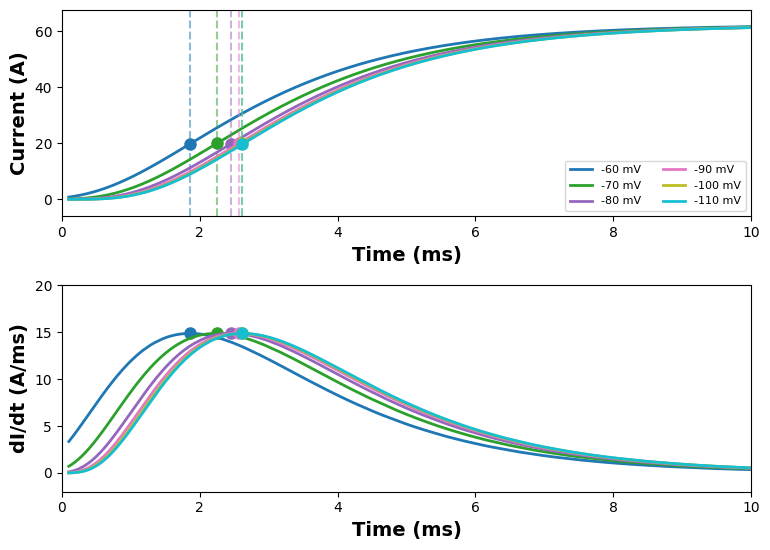

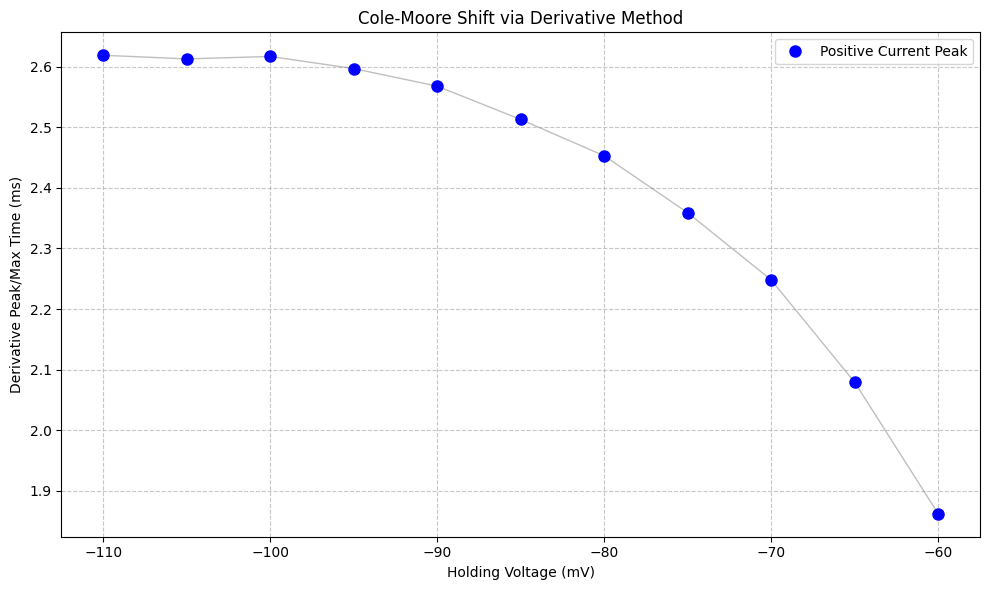


Derivative Peak/Maximum Analysis Results:


,Sweep,Peak/Max Time (ms),Peak/Max Value,True Peak,Current Type
0,-60 mV,1.862,14.868823,Yes,Positive
1,-65 mV,2.079,14.868951,Yes,Positive
2,-70 mV,2.248,14.868951,Yes,Positive
3,-75 mV,2.359,14.868951,Yes,Positive
4,-80 mV,2.453,14.868998,Yes,Positive
5,-85 mV,2.513,14.868823,Yes,Positive
6,-90 mV,2.568,14.868951,Yes,Positive
7,-95 mV,2.597,14.868951,Yes,Positive
8,-100 mV,2.617,14.868951,Yes,Positive
9,-105 mV,2.613,14.868951,Yes,Positive


Results saved to cole_moore_derivative_peak_results.csv


In [21]:
"""
Script for using the derivative_analysis module for Cole-Moore analysis

This script assumes that 'raw_data' has already been loaded and is available
in the environment. It performs derivative peak analysis and visualizes the results.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from google.colab import files

# Import the derivative_analyzer module
from derivative_analysis import analyze_derivative_peaks, visualize_derivative_peaks

# --- Run Derivative Peak Analysis ---
if 'data' in locals() and data is not None:
    print("\n--- Configuring Derivative Peak Analysis ---")

    # --- Set Analysis Parameters ---
    start_time = 0.1         # ms, Start time for analysis (None to use all data)
    window_length = 11       # Window length for smoothing (must be odd)
    polyorder = 3           # Polynomial order for Savitzky-Golay filter
    min_peak_height = None     # Minimum height for peak detection (None for auto)
    peak_prominence = 1e-7   # Minimum prominence for peak detection
    num_sweeps = 6             # Num of sweeps to plot

    # Display parameters
    x_min = 0                  # ms, Minimum time for x-axis in plots
    x_max = 10                 # ms, Maximum time for x-axis in plots
    y_min_deriv = -2          # Minimum value for y-axis in derivative plot (None for auto)
    y_max_deriv =20 # Maximum value for y-axis in derivative plot (None for auto)

    print(f"Analysis Start Time: {start_time} ms")
    print(f"Smoothing Window: {window_length} points")
    print(f"Polynomial Order: {polyorder}")
    print(f"Plot Range X: {x_min} to {x_max} ms")
    print(f"Plot Range Y for derivative: {y_min_deriv} to {y_max_deriv} (auto if None)")

    # Run the analysis on data
    print("\nAnalyzing data with derivative peak method...")
    derivative_results = analyze_derivative_peaks(
        data,
        time_col='Time (ms)',
        start_time=start_time,
        window_length=window_length,
        polyorder=polyorder,
        min_peak_height=min_peak_height,
        peak_prominence=peak_prominence,
        early_activation_bias= False
    )

    # Visualize the results
    if derivative_results:
        results_df = visualize_derivative_peaks(
            data,
            derivative_results,
            time_col='Time (ms)',
            window_length=window_length,
            polyorder=polyorder,
            start_time=start_time,
            x_min=x_min,
            x_max=x_max,
            max_sweeps=num_sweeps,
            y_min_deriv=y_min_deriv,
            y_max_deriv=y_max_deriv
        )

        # Save results to CSV
        if results_df is not None:
            results_filename = "cole_moore_derivative_peak_results.csv"
            results_df.to_csv(results_filename, index=False)
            print(f"Results saved to {results_filename}")

else:
    print("\n--- Skipping Derivative Peak Analysis ---")
    print("Variable 'data' not found. Please run the data import cell first.")


--- Comparing Cole-Moore Analysis Methods ---
All result files found. Proceeding with comparison.
Loading Exponential Fit data from cole_moore_exp_fit_results_single.csv
Loading Trace Alignment data from cole_moore_shift_results.csv
Loading Derivative Peak data from cole_moore_derivative_peak_results.csv


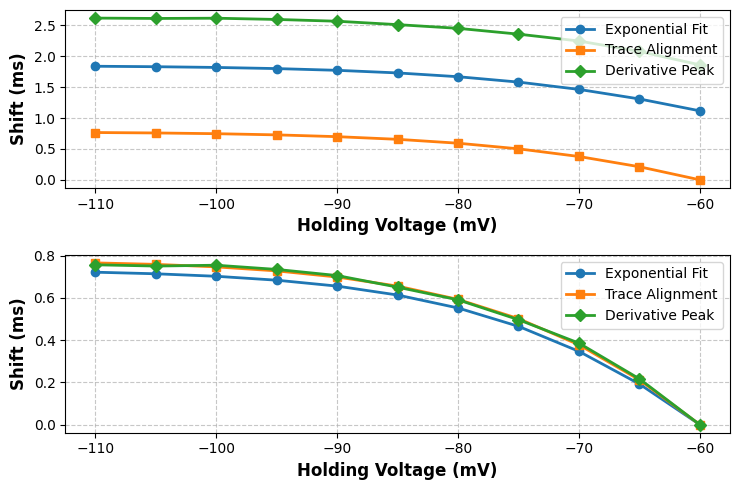


Baseline Information:

Exponential Fit:
  Original min: 1.1173 ms
  Original max: 1.8392 ms
  Range: 0.7219 ms

Trace Alignment:
  Original min: -0.0000 ms
  Original max: 0.7660 ms
  Range: 0.7660 ms

Derivative Peak:
  Original min: 1.8620 ms
  Original max: 2.6190 ms
  Range: 0.7570 ms

Summary Statistics per Method:

Exponential Fit:
  Mean crossing time: 1.6309 ms
  Median crossing time: 1.7310 ms

Trace Alignment:
  Mean shift: 0.5491 ms
  Median shift: 0.6560 ms

Derivative Peak:
  Mean peak time: 2.4116 ms
  Median peak time: 2.5130 ms

--- Comparison Complete ---


In [23]:
"""
Script for using the cole_moore_comparator module

This script assumes that the analysis result CSV files exist in the current directory.
It compares the Cole-Moore shift results from different analysis methods.
"""

# Import the cole_moore_comparator module
from compare_methods import compare_cole_moore_methods

# --- Run Cole-Moore Methods Comparison ---
print("\n--- Comparing Cole-Moore Analysis Methods ---")

# Specify paths to the CSV files from each method
exp_file = "cole_moore_exp_fit_results_single.csv"
shift_file = "cole_moore_shift_results.csv"
derivative_file = "cole_moore_derivative_peak_results.csv"

# Check for existing files
import os
all_files_exist = True

for file_path, method_name in [
    (exp_file, "Exponential Fit"),
    (shift_file, "Trace Alignment"),
    (derivative_file, "Derivative Peak")
]:
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found. {method_name} results will not be included.")
        all_files_exist = False

if all_files_exist:
    print("All result files found. Proceeding with comparison.")
else:
    print("Note: Missing files will be skipped in the comparison.")

# Run comparison
compare_cole_moore_methods(
    exp_csv=exp_file,
    shift_csv=shift_file,
    derivative_csv=derivative_file,
    invert_shifts=True
)

print("\n--- Comparison Complete ---")


Loading Exponential Fit data from cole_moore_exp_fit_results_single.csv
Loading Trace Alignment data from cole_moore_shift_results.csv
Loading Derivative Peak data from cole_moore_derivative_peak_results.csv
Found 11 valid derivative peak measurements
Exponential Fit vs Derivative correlation: r = 0.9995, p = 7.5209e-15, n = 11
Trace Alignment vs Derivative correlation: r = 0.9997, p = 1.3923e-15, n = 11


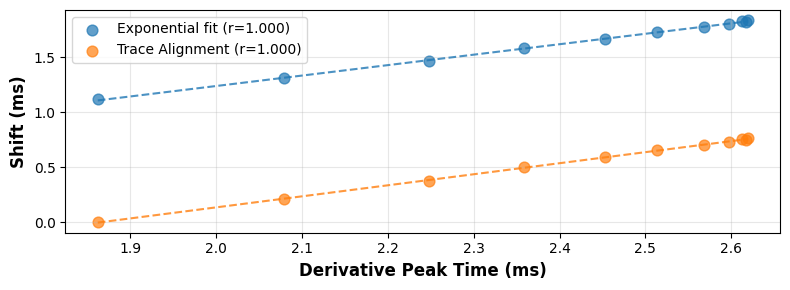


Correlation analysis complete using derivative peak method as reference


In [24]:
from cole_moore_correlation import correlate_cole_moore

correlate_cole_moore(
    exp_csv="cole_moore_exp_fit_results_single.csv",
    shift_csv="cole_moore_shift_results.csv",
    derivative_csv="cole_moore_derivative_peak_results.csv",
    invert_shifts=True
)

Cole-Moore Methods Correlation Analysis with Baselined Data
Loaded Exponential Fit data from cole_moore_exp_fit_results_single.csv
Loaded Trace Alignment data from cole_moore_shift_results.csv
Loaded Derivative Peak data from cole_moore_derivative_peak_results.csv
Derivative data baselined (subtracted 1.862 ms)
Found 11 valid derivative peak measurements
Exponential data baselined (subtracted 1.117 ms)
Exponential Fit vs Derivative correlation: r = 0.9995, p = 7.5209e-15, n = 11
Trace alignment data baselined (subtracted -0.000 ms)
Trace Alignment vs Derivative correlation: r = 0.9997, p = 1.3923e-15, n = 11


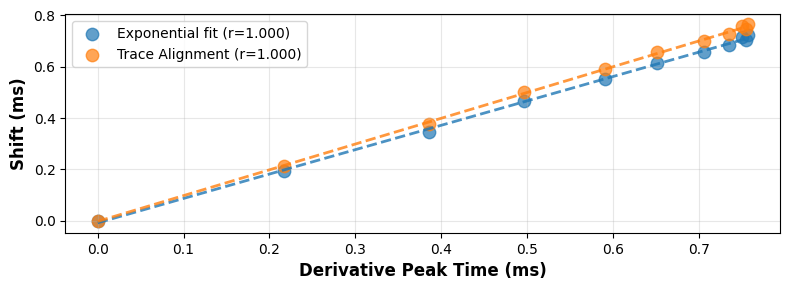


Correlation analysis complete using baselined data


In [25]:
from cole_moore_baseline_correlation import correlate_cole_moore_baselined

# Usage example for Google Colab:
print("Cole-Moore Methods Correlation Analysis with Baselined Data")
print("=" * 60)

# Specify your CSV file paths here
exp_file = "cole_moore_exp_fit_results_single.csv"
shift_file = "cole_moore_shift_results.csv"
derivative_file = "cole_moore_derivative_peak_results.csv"

# Run the correlation analysis with baselined data
correlate_cole_moore_baselined(
    exp_csv=exp_file,
    shift_csv=shift_file,
    derivative_csv=derivative_file,
    invert_shifts=True  # Set to False if you don't want to invert trace alignment shifts
)

In [ ]:
from compare_multiple_methods import compare_multiple_methods

In [ ]:
import importlib
import compare_multiple_methods

# Reload the module (so you pick up any recent edits or re-uploads)
importlib.reload(compare_multiple_methods)

# Now you can safely import the function again
from compare_multiple_methods import compare_multiple_methods

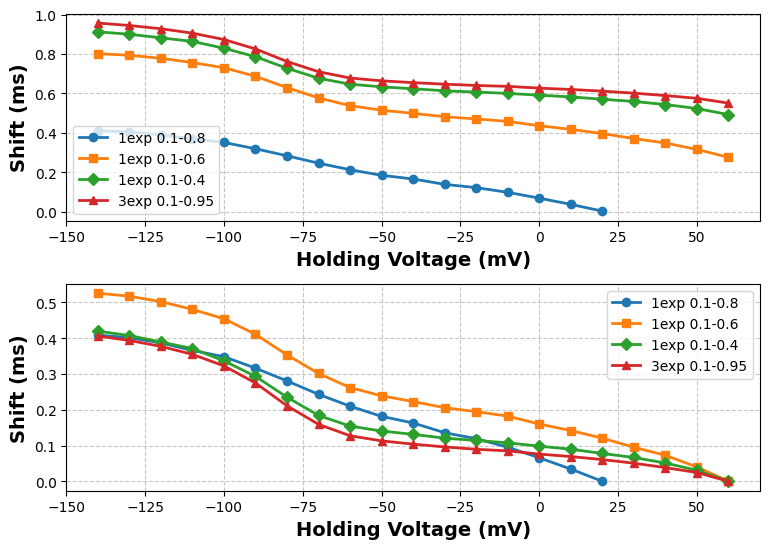

1exp 0.1-0.8: min=0.0032 ms, max=0.4118 ms, range=0.4086 ms
1exp 0.1-0.6: min=0.2760 ms, max=0.8018 ms, range=0.5257 ms
1exp 0.1-0.4: min=0.4927 ms, max=0.9124 ms, range=0.4197 ms
3exp 0.1-0.95: min=0.5508 ms, max=0.9570 ms, range=0.4062 ms


In [ ]:
csv_files = {
    '1exp 0.1-0.8': 'cole_moore_exp_fit_results_single10-80.csv',
    '1exp 0.1-0.6': 'cole_moore_exp_fit_results_single10-60.csv',
    '1exp 0.1-0.4': 'cole_moore_exp_fit_results_single10-40.csv',
    '3exp 0.1-0.95': '/content/cole_moore_exp_fit_results_triple.csv'
}

compare_multiple_methods(csv_files, invert_shifts=True)


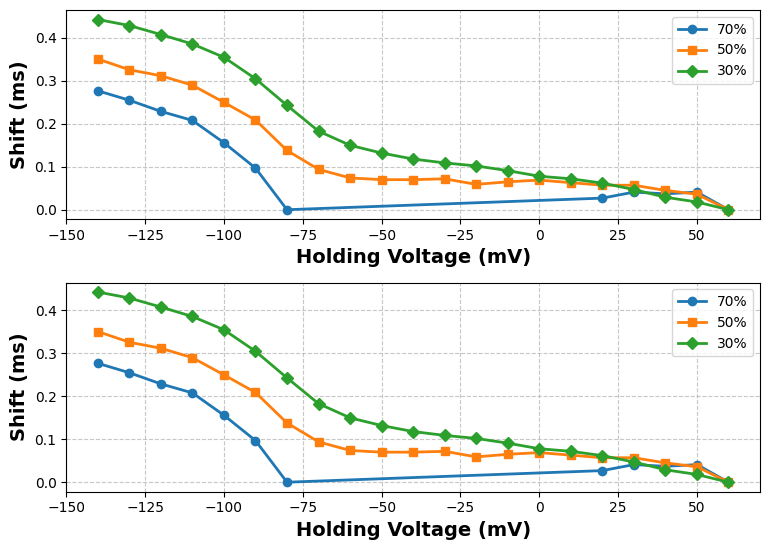

70%: min=-0.0000 ms, max=0.2770 ms, range=0.2770 ms
50%: min=-0.0000 ms, max=0.3510 ms, range=0.3510 ms
30%: min=-0.0000 ms, max=0.4430 ms, range=0.4430 ms


In [ ]:
csv_files = {
    '70%': 'cole_moore_shift_results0.7.csv',
    '50%': 'cole_moore_shift_results0.5.csv',
    '30%': 'cole_moore_shift_results0.3.csv',
}

compare_multiple_methods(csv_files, invert_shifts=True)